<a href="https://colab.research.google.com/github/drawnator/PLN-grupo-19/blob/main/Grupo19_PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ferramenta Otimizadora De Aleatoriedade em senhas
---
Modelo de linguagem que auxilia a tornar senhas mais fortes, com base em critérios de fortificação de senhas como o [zxcvbn](https://github.com/dropbox/zxcvbn) e em [senhas vazadas da plataforma rockyou](https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt).

A aplicação prática do modelo é analisar a senha de entrada, identificar se ela é fraca ou forte segundo critérios predefinidos, se é uma senha comum (presentes na base de dados de senhas vazadas) ou não, e, por fim, dar sugestões pontuais de como tornar a senha mais improvável de adivinhar.

Assuntos:
- Análise de frequência
- Masked language model

Tecnologias utilizadas:
- Bert
- RNN
- Árvores de decisão
- Princípios de senha aleatória

##Preparando o ambiente de execução (imports necessários)

In [ ]:
!pip install zxcvbn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 7.7 MB/s eta 0:00:00


In [ ]:
import requests
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, SimpleRNN
from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.utils import Sequence
from zxcvbn import zxcvbn

import matplotlib.pyplot as plt
from google.colab import drive
import pickle

## Preparando os dados

In [ ]:
# RECOMENDO FORTEMENTE BAIXAR E ARRASTAR MANUALMENTE ATÉ ARTIGOS, ISSO AQUI DEMORA MT \/
url = "https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt"
# response = requests.get(url)
# data = response.text
#...

In [ ]:
with open("rockyou.txt", "r", encoding='latin-1') as f:
  df = pd.DataFrame(f.readlines(), columns=['password'])

In [ ]:
df['password'] = df['password'].str.replace('\n', '')

In [ ]:
# if not os.path.exists("rockyou.csv"):
#   df.to_csv("rockyou.csv")

In [ ]:
df = df[df['password'].str.len() > 1]
display(df.shape)

(14344345, 1)

In [ ]:
df.shape

(14344345, 1)

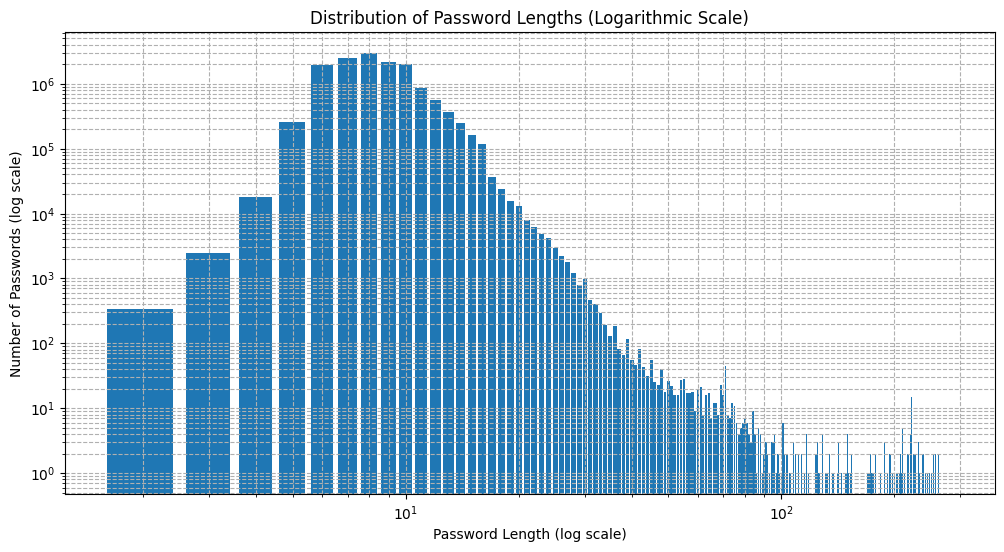

In [ ]:
df['password_length'] = df['password'].str.len()

length_counts = df['password_length'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(length_counts.index, length_counts.values)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Password Length (log scale)')
plt.ylabel('Number of Passwords (log scale)')
plt.title('Distribution of Password Lengths (Logarithmic Scale)')
plt.grid(True, which="both", ls="--")
plt.show()

# Métodos de avaliar a qualidade de uma senha

## RNN

Previsibilidade de caracteres, com base em uma parte da senha o quão fácil é prever o resto dela?


## Tokenização

Transformando os caracteres de uma senha em tokens para que eles estejam no formato adequado para o processamento.

In [ ]:
all_chars = sorted(list(set(''.join(df['password']))))
char_to_int = {char: i for i, char in enumerate(all_chars)}
int_to_char = {i: char for char, i in char_to_int.items()}

In [ ]:
char_to_int['[MASK]'] = len(char_to_int)
char_to_int['[CLS]'] = len(char_to_int)
char_to_int['[SEP]'] = len(char_to_int)
char_to_int['[PAD]'] = len(char_to_int)
int_to_char = {i: char for char, i in char_to_int.items()}

In [ ]:
class RNNTokenizer():
  def __init__(self, char_to_int,int_to_char,max_length = 32):
    self.char_to_int = char_to_int
    self.int_to_char = int_to_char
    self.mask_token_id = char_to_int['[MASK]']
    self.cls_token_id = char_to_int['[CLS]']
    self.sep_token_id = char_to_int['[SEP]']
    self.pad_token_id = char_to_int['[PAD]']
    self.max_length = max_length
    self.vocab_size = len(char_to_int)

  def __call__(self,text):
    token = [self.pad_token_id] * self.max_length
    text = f"{text:>{self.max_length}}"
    # print(text)
    for i in range(self.max_length):
      token[-i] = char_to_int[text[-i]]

    # for i in range(self.max_length):
    #   if (i < len(text)):
    #     token.append(char_to_int[text[i]])
    #   else:
    #     token.append(char_to_int['[PAD]'])

    return token

In [ ]:
rnntokenizer = RNNTokenizer(char_to_int,int_to_char)

In [ ]:
class RNNDataloader(Sequence):
  def __init__(self,dataframe,tokenizer,batch_size=100):
    self.dataframe = dataframe
    self.tokenizer = tokenizer
    self.batch_size = batch_size

  def mask_and_tokens(self,password):
      i = np.random.randint(1, min(len(password),self.tokenizer.max_length))
      label = self.tokenizer.char_to_int[password[i]]
      input_seq = self.tokenizer(password[:i])

      # input_seq += [self.tokenizer.mask_token_id]
      # input_seq += [self.tokenizer.pad_token_id] * (self.tokenizer.max_length - len(input_seq))
      return input_seq,label

  def __len__(self):
    return len(self.dataframe) // self.batch_size

  def __getitem__(self, idx):
    batch = self.dataframe[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_inputs = []
    batch_labels = []
    for password in batch:
      input_seq, label = self.mask_and_tokens(password)
      batch_inputs.append(input_seq)
      batch_labels.append(label)
    return np.array(batch_inputs), np.array(batch_labels)

In [ ]:
dataloader = RNNDataloader(df['password'],rnntokenizer)

In [ ]:
df["password"][0]

'123456'

In [ ]:
dataloader[0]

(array([[ 4,  4,  4, ...,  4, 21, 22],
        [ 4,  4,  4, ..., 22, 23, 24],
        [ 4,  4,  4, ..., 21, 22, 23],
        ...,
        [ 4,  4,  4, ..., 89, 86, 73],
        [ 4,  4,  4, ...,  4, 81, 77],
        [ 4,  4,  4, ...,  4, 84, 86]]),
 array([23, 25, 24, 69, 73, 86, 27, 79, 22, 23, 73, 80, 75, 83, 93, 71, 23,
        71, 73, 73, 21, 89, 20, 73, 86, 89, 80, 69, 73, 82, 87, 86, 73, 82,
        72, 86, 82, 73, 83, 23, 70, 73, 73, 80, 73, 76, 73, 22, 84, 76, 69,
        83, 86, 69, 91, 75, 73, 86, 93, 73, 77, 83, 77, 86, 81, 77, 69, 83,
        73, 87, 69, 26, 69, 77, 77, 69, 88, 73, 90, 93, 88, 27, 83, 86, 83,
        69, 83, 88, 86, 88, 75, 73, 86, 83, 83, 73, 73, 82, 71, 77]))

In [ ]:
# drive.mount('/content/drive')

# char_to_int = '/content/drive/MyDrive/my_models/char_to_int.pkl'
# int_to_char = '/content/drive/MyDrive/my_models/int_to_char.pkl'

# with open(char_to_int, 'wb') as f:
#     pickle.dump(char_to_int, f)

# with open(int_to_char, 'wb') as f:
#     pickle.dump(int_to_char, f)

In [ ]:
# drive.mount('/content/drive')
# with open(char_to_int, 'rb') as f:
#     char_to_int = pickle.load(f)

# with open(int_to_char, 'rb') as f:
#     int_to_char = pickle.load(f)

## Dividindo os dados em conjuntos de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def create_train_val_test_arrays(df, dataloader, tokenizer, test_size=0.2, val_size=0.5,):
    train_df, temp_df = train_test_split(df, test_size=test_size, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=val_size, random_state=42)

    train_dataloader = dataloader(train_df, tokenizer,batch_size=1000)
    val_dataloader = dataloader(val_df, tokenizer,batch_size=1000)
    test_dataloader = dataloader(test_df, tokenizer,batch_size=1000)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
train_dataloader,val_dataloader,test_dataloader = create_train_val_test_arrays(df["password"], RNNDataloader, rnntokenizer)

## Definindo o modelo

In [ ]:
#https://colab.research.google.com/drive/1mts5E3yAd1irLzS7Ei6UtwbG773C87DB?usp=sharing
model = Sequential([
    Embedding(
        input_dim=rnntokenizer.vocab_size,
        output_dim=100,
        input_shape=(rnntokenizer.max_length,)),
    Bidirectional(SimpleRNN(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(SimpleRNN(64, return_sequences=False)),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.05),
    Dense(64, activation='relu'),
    Dense(rnntokenizer.vocab_size, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(
    train_dataloader,
    validation_data=(val_dataloader),
    epochs=3,
    batch_size=256,
    verbose=1)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

model_save_path = '/content/drive/MyDrive/my_models/rnn_password_model4.keras'

import os
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model.save(model_save_path)

In [ ]:
from google.colab import drive
import tensorflow as tf

drive.mount('/content/drive')

model_load_path = '/content/drive/MyDrive/my_models/rnn_password_model3.keras'

model = tf.keras.models.load_model(model_load_path)
model.summary()

Mounted at /content/drive


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 100)        │        21,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 218)            │        14,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,524 (1.04 MB)

 Trainable params: 91,174 (356.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 182,350 (712.31 KB)

## métricas de modelo

In [ ]:
class RnnMetrics():
  def __init__(self,model:tf.keras.models.Model,tokenizer:RNNTokenizer):
    self.model = model
    self.tokenizer = tokenizer

  def preencher_senha(self,senha_base):
    while len(senha_base) < self.tokenizer.max_length:
      senha_base += self.prever_proxima(senha_base)
    return senha_base

  def prever_proxima(self,palavras):
      seq = self.tokenizer(palavras)
      seq = np.array([seq])
      pred = self.model.predict(seq, verbose=0)
      idx = np.argmax(pred)
      return self.tokenizer.int_to_char[idx]

  def get_probs(self,palavra,temperatura=1.0):
    seq = self.tokenizer(palavra)
    seq = np.array([seq])
    pred = self.model.predict(seq, verbose=0)
    logits = np.log(pred + 1e-9) / temperatura  # evita log(0)
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    return probs

  def get_char_rarity(self,probs,char):
    char_token = self.tokenizer.char_to_int[char]
    smaller_than = np.where(probs < probs[0][char_token])[0]
    return smaller_than.shape[0]/self.tokenizer.vocab_size

  def get_rarity(self,password):
    rarity = []
    for part in range(len(password)):
      probs = self.get_probs(password[:part])
      rarity.append(self.get_char_rarity(probs,password[part]))
    return rarity

  def get_char_proportional_probability(self,probs,char):
    char_token = self.tokenizer.char_to_int[char]
    return probs[0][char_token]

  def get_proportional_probability(self,password):
    rarity = []
    for part in range(len(password)):
      probs = self.get_probs(password[:part])
      rarity.append(self.get_char_proportional_probability(probs,password[part]))
    return rarity

  def get_weighted_scores(self,password,weight=[1,1]):
    rarity = self.get_rarity(password)
    proportional_probability = self.get_proportional_probability(password)
    return (np.array(rarity) * weight[0] + np.array(proportional_probability) * weight[1])/sum(weight)

In [ ]:
rnnmetrics = RnnMetrics(model,rnntokenizer)

In [ ]:
rnnmetrics.preencher_senha("passwo")

'password123450000000000000000800'

In [ ]:
rnnmetrics.get_proportional_probability("password12345")

[np.float32(0.01793929),
 np.float32(0.19665958),
 np.float32(0.06374317),
 np.float32(0.25482658),
 np.float32(0.010358805),
 np.float32(0.1253093),
 np.float32(0.27993187),
 np.float32(0.5268756),
 np.float32(0.102144256),
 np.float32(0.18812832),
 np.float32(0.6868829),
 np.float32(0.60398436),
 np.float32(0.2464673)]

### visualizar métricas do modelo

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_score_heatmap(password, scores):
    heatmap_data = np.array(scores).reshape(1, -1)

    plt.figure(figsize=(len(password) * 0.5, 1))
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto', vmin=0.0, vmax=1)
    plt.colorbar(label='Score (0-1)')

    for i in range(len(password)):
        plt.text(i, 0, password[i], ha='center', va='center', color='white' if heatmap_data[0, i] < 0.5 else 'black')

    plt.title(f"{password}")
    plt.yticks([])
    plt.xticks([])
    plt.show()


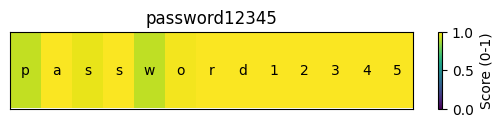

0.9784756527875794


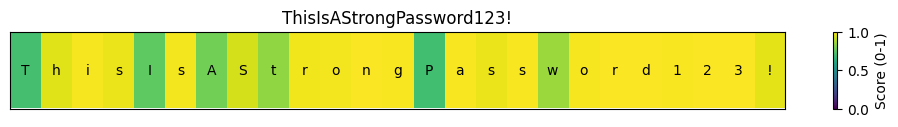

0.9308256880733946


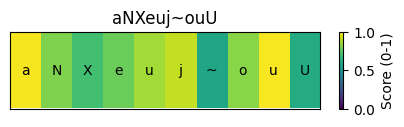

0.8055045871559633


In [ ]:
password = "password12345"
rarity = rnnmetrics.get_rarity(password)
plot_score_heatmap(password, rarity)
print(sum(rarity)/len(rarity))

password = "ThisIsAStrongPassword123!"
rarity = rnnmetrics.get_rarity(password)
plot_score_heatmap(password, rarity)
print(sum(rarity)/len(rarity))

password = "aNXeuj~ouU"
rarity = rnnmetrics.get_rarity(password)
plot_score_heatmap(password, rarity)
print(sum(rarity)/len(rarity))

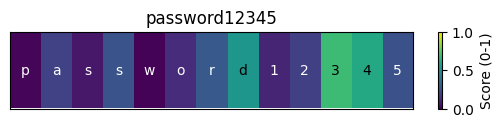

0.25409627


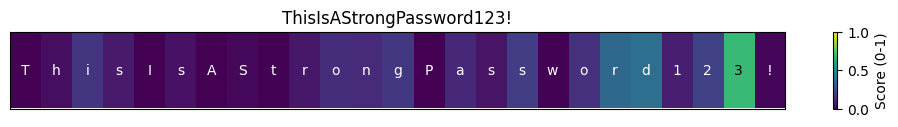

0.119301364


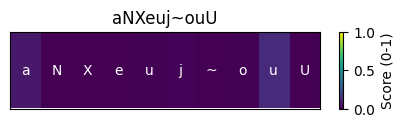

0.021783138


In [ ]:
password = "password12345"
proportional = rnnmetrics.get_proportional_probability(password)
plot_score_heatmap(password, proportional)
print(sum(proportional)/len(proportional))

password = "ThisIsAStrongPassword123!"
proportional = rnnmetrics.get_proportional_probability(password)
plot_score_heatmap(password, proportional)
print(sum(proportional)/len(proportional))


password = "aNXeuj~ouU"
proportional = rnnmetrics.get_proportional_probability(password)
plot_score_heatmap(password, proportional)
print(sum(proportional)/len(proportional))


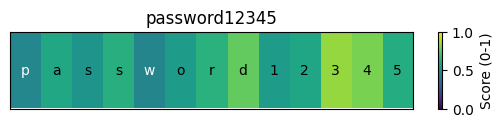

0.6162859557529065


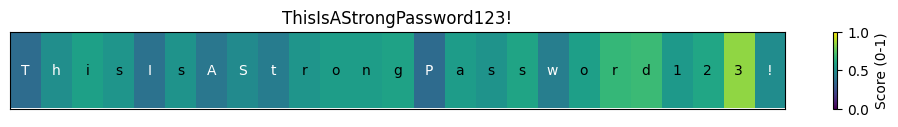

0.5250635245336949


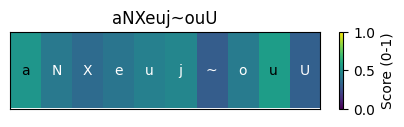

0.41364386216918686


In [ ]:
password = "password12345"
weighted = rnnmetrics.get_weighted_scores(password,[1,1])
plot_score_heatmap(password,weighted )
print(sum(weighted)/len(weighted))

password = "ThisIsAStrongPassword123!"
weighted = rnnmetrics.get_weighted_scores(password,[1,1])
plot_score_heatmap(password,weighted )
print(sum(weighted)/len(weighted))

password = "aNXeuj~ouU"
weighted = rnnmetrics.get_weighted_scores(password,[1,1])
plot_score_heatmap(password,weighted )
print(sum(weighted)/len(weighted))

## métricas

## Bert

In [ ]:
#https://colab.research.google.com/drive/1Suv_JhRhoYNOCHtrGQwqZQO18nMXHEfq?usp=sharing
def mask_tokens(inputs, tokenizer, mlm_probability=0.10):
    inputs = np.array(inputs)
    labels = np.copy(inputs)

    rand = np.random.rand(*inputs.shape)
    mask_arr = (rand < mlm_probability)

    special_tokens = [tokenizer.cls_token_id, tokenizer.sep_token_id]
    for special_id in special_tokens:
        mask_arr[inputs == special_id] = False

    inputs[mask_arr] = tokenizer.mask_token_id

    labels[~mask_arr] = 0

    return inputs, labels

In [ ]:
def create_train_val_test_datasets(df, tokenizer, test_size=0.10, val_size=0.15, batch_size=8,max=None):

    if max:
        df = df.head(max)

    train_df, temp_df = train_test_split(df, test_size=test_size, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=val_size, random_state=42)

    def df_to_dataset(dataframe, tokenizer, batch_size):
        tokenized_passwords = dataframe['tokenized_password'].tolist()

        masked_inputs = []
        masked_labels = []
        for tokens in tokenized_passwords:
            inputs, labels = mask_tokens(tokens, tokenizer)
            masked_inputs.append(inputs)
            masked_labels.append(labels)

        input_ids = tf.constant(masked_inputs, dtype=tf.int32)
        labels = tf.constant(masked_labels, dtype=tf.int32)

        dataset = tf.data.Dataset.from_tensor_slices((input_ids, labels))
        return dataset.shuffle(1000).batch(batch_size)

    train_dataset = df_to_dataset(train_df, tokenizer, batch_size)
    val_dataset = df_to_dataset(val_df, tokenizer, batch_size)
    test_dataset = df_to_dataset(test_df, tokenizer, batch_size)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_ds, val_ds, test_ds = create_train_val_test_datasets(df, dummy_tokenizer, batch_size=8)

# Capítulo Que Analise Senhas Usando ZXCVBN No Nosso Colab

In [ ]:
def zxcvbneficar(senhas):
  for s in senhas:
    resultado = zxcvbn(s)
    print(resultado)
    print(f"Senha: {s}")
    print(f"  - Pontuação (0 a 4): {resultado['score']}")
    print(f"  - Feedback: {resultado['feedback']['warning'] or 'Nenhum aviso'}")
    print(f"  - Sugestões: {resultado['feedback']['suggestions'] or 'Nenhuma'}")
    print(f"  - Tempo de quebra: {resultado['crack_times_display']['offline_fast_hashing_1e10_per_second']}")
    print("--------------------------------------------------------------------------------------------------")


senhas = [
    "password12345",
    "ThisIsAStrongPassword123!",
    "aNXeuj~ouU"
]

zxcvbneficar(senhas)

{'password': 'password12345', 'guesses': Decimal('15000'), 'guesses_log10': 4.176091259055681, 'sequence': [{'pattern': 'dictionary', 'i': 0, 'j': 7, 'token': 'password', 'matched_word': 'password', 'rank': 2, 'dictionary_name': 'passwords', 'reversed': False, 'l33t': False, 'base_guesses': 2, 'uppercase_variations': 1, 'l33t_variations': 1, 'guesses': 50, 'guesses_log10': 1.6989700043360185}, {'pattern': 'dictionary', 'i': 8, 'j': 12, 'token': '12345', 'matched_word': '12345', 'rank': 6, 'dictionary_name': 'passwords', 'reversed': False, 'l33t': False, 'base_guesses': 6, 'uppercase_variations': 1, 'l33t_variations': 1, 'guesses': 50, 'guesses_log10': 1.6989700043360185}], 'calc_time': datetime.timedelta(microseconds=2731), 'crack_times_seconds': {'online_throttling_100_per_hour': Decimal('540000.0000000000299760216649'), 'online_no_throttling_10_per_second': Decimal('1500'), 'offline_slow_hashing_1e4_per_second': Decimal('1.5'), 'offline_fast_hashing_1e10_per_second': Decimal('0.00000